In [1]:
import torch
from torch import nn
import numpy as np
import os
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision import datasets, models
from torchvision.transforms import v2
from utils.graph_utils import lossGraph
import time
%matplotlib inline

SEED = 42
THRESHOLD = 0.5

np.random.seed(SEED)

In [2]:
data_dir = 'data'

In [3]:
image_height = 256
image_width = 256
batch_size = 16

In [4]:
transform = v2.Compose([
  v2.Resize(size=(image_height, image_width)),
  v2.RandomHorizontalFlip(),
  v2.ToImage(), 
  v2.ToDtype(torch.float32, scale=True)
])

In [5]:
dataset = datasets.ImageFolder(os.path.join(data_dir), transform=transform)

In [6]:
training_size = int(len(dataset)*0.8) #80% of data
validation_size = len(dataset) - training_size #20% of data
print(f"Dataset Size: {len(dataset)}")
print(f"Training Size: {training_size}")
print(f"Validation Size: {validation_size}")

Dataset Size: 420
Training Size: 336
Validation Size: 84


In [7]:
training_data, validation_data = random_split(dataset, [training_size, validation_size])

In [8]:
train_dataloader = DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(dataset=validation_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
device = (
  "cuda"
  if torch.cuda.is_available()
  else "mps"
  if torch.backends.mps.is_available()
  else
  "cpu"
)
print(f"Using {device} device")

Using cpu device


In [10]:
model = models.resnet18(weights='IMAGENET1K_V1')

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
last_model_input = model.fc.in_features #512
model.fc = nn.Linear(last_model_input, 1)
model = model.to(device)

In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  train_loss, num_correct = 0, 0
  model.train()
  
  for batch, (X, y) in enumerate(dataloader):
    X, y, X.to(device), y.to(device)
    y = y.type(torch.float)

    pred = model(X).reshape(16,)
    pred = nn.Sigmoid()(pred)
    
    loss = loss_fn(pred, y)
    train_loss += loss.item()
    num_correct += ((pred > THRESHOLD) == y).sum().item()
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    if batch % 10 == 0:
      loss, current = loss.item(), (batch+1) * len(X)
      print(f"Loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

  avgTrainingLoss = train_loss / len(dataloader)
  trainingAccuracy = (num_correct / size) * 100
  
  return avgTrainingLoss, trainingAccuracy

In [16]:
def valid(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  number_batches = len(dataloader)

  model.eval()

  valid_loss, num_correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y = y.type(torch.float)
      
      pred = model(X).reshape(16,)
      pred = nn.Sigmoid()(pred)

      valid_loss += loss_fn(pred, y).item()
      num_correct += ((pred > THRESHOLD) == y).sum().item() 

  avgValidationLoss = valid_loss / number_batches
  validationAccuracy = (num_correct / size) * 100
  print(f"Validation Error --- Accuracy: {validationAccuracy:.1f}%, Avg Loss: {avgValidationLoss:>8f} \n")

  return avgValidationLoss, validationAccuracy

In [17]:
def main():  
  epochs = 20
  training_loss, validation_loss = [], []
  training_accuracy, validation_accuracy = [], []
  tik = time.time()

  for t in range(epochs):
    print(f"Epoch {t+1} \n -------------------------------")
    avgTrainingLoss, trainingAccuracy = train(train_dataloader, model, loss_fn, optimizer)
    training_loss.append(avgTrainingLoss)
    training_accuracy.append(trainingAccuracy)

    avgValidationLoss, validationAccuracy = valid(valid_dataloader, model, loss_fn)
    validation_loss.append(avgValidationLoss)
    validation_accuracy.append(validationAccuracy)

  tok = time.time()
    
  lossGraph(training_loss, validation_loss, training_accuracy, validation_accuracy, epochs)

  print(f"Execution finished, {tok-tik} seconds elapsed for model training")

Epoch 1 
 -------------------------------
Loss: 0.729644 [   16/  336]
Loss: 0.192549 [  176/  336]
Loss: 0.323016 [  336/  336]
Validation Error --- Accuracy: 51.2%, Avg Loss: 31.673463 

Epoch 2 
 -------------------------------
Loss: 0.134980 [   16/  336]
Loss: 0.224969 [  176/  336]
Loss: 0.130566 [  336/  336]
Validation Error --- Accuracy: 75.0%, Avg Loss: 0.694963 

Epoch 3 
 -------------------------------
Loss: 0.153838 [   16/  336]
Loss: 0.019368 [  176/  336]
Loss: 0.031900 [  336/  336]
Validation Error --- Accuracy: 89.3%, Avg Loss: 0.122765 

Epoch 4 
 -------------------------------
Loss: 0.042311 [   16/  336]
Loss: 0.023536 [  176/  336]
Loss: 0.312073 [  336/  336]
Validation Error --- Accuracy: 88.1%, Avg Loss: 0.148367 

Epoch 5 
 -------------------------------
Loss: 0.090433 [   16/  336]
Loss: 0.638213 [  176/  336]
Loss: 0.094673 [  336/  336]
Validation Error --- Accuracy: 72.6%, Avg Loss: 1.706516 

Epoch 6 
 -------------------------------
Loss: 0.025126 [ 

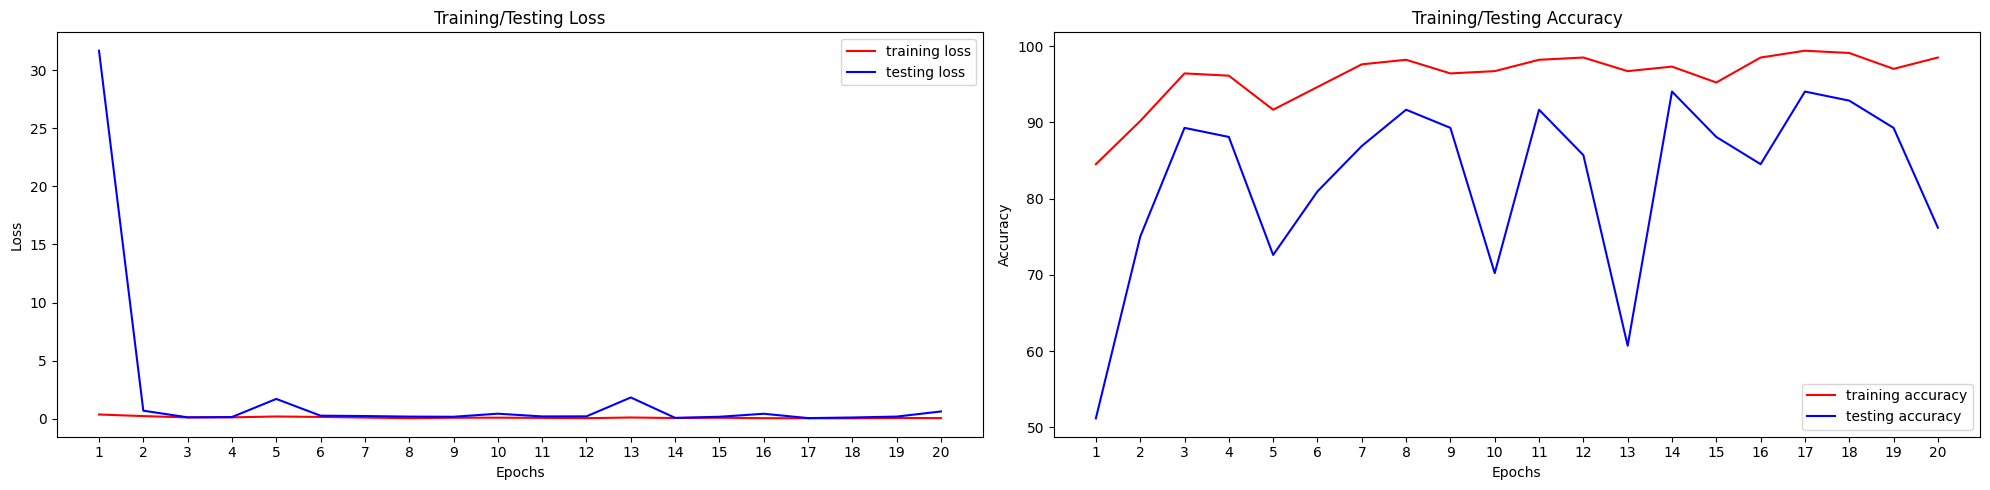

Execution finished, 1376.6160678863525 seconds elapsed for model training


In [18]:
if __name__ == "__main__":
  main()